In [1]:
import sys
import os
import random
import gc
import time
import torch
import numpy as np
import pandas as pd
import ast
from tqdm import tqdm
from scipy.stats import spearmanr, pearsonr, kendalltau, rankdata
from sklearn.metrics import ndcg_score
from transformers import AutoModelForCausalLM, AutoTokenizer
from accelerate import Accelerator

current_dir = os.getcwd()
parent_dir = os.path.abspath(os.path.join(current_dir, '..'))
sys.path.append(parent_dir)
from SHapRAG import *

/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df= pd.read_csv("../data/synthetic_data/20_synergy_hard_negatives.csv",index_col=False, sep=";")
# df= pd.read_csv("../data/complementary.csv")

In [ ]:
df.context[1]

In [ ]:
docs = [
# "The weather in Chorvoq is stormy today.",
"Chorvoq is the capital of Narniya.",
# "The sun is shining in Galaba today",
"Nurik is the capital of Suvsambil.",
"Narniya borders several countries including Suvsambil.",
"The currency used in Narniya is the Euro.",
"Narniya is the biggest country in the Olam",
# "Chorvoq hosted the Summer Olympics in 1900 and 1924.",
"The capital of Narniya is Chorvoq.",
# "Suvsambil uses the Euro as well.",
"It is cloudy in Nurik today."
]
query = "What is the capital of the biggest country in the Olam?"
# Parameters
NUM_RETRIEVED_DOCS = len(docs)


In [3]:
SEED = 42
# Initialize Accelerator
accelerator_main = Accelerator(mixed_precision="fp16")

# Load Model
if accelerator_main.is_main_process:
    print("Main Script: Loading model...")
# model_path = "mistralai/Mistral-7B-Instruct-v0.3"
# model_path = "meta-llama/Llama-3.1-8B-Instruct"
model_path = "Qwen/Qwen2.5-3B-Instruct"

model_cpu = AutoModelForCausalLM.from_pretrained(
    model_path,
    torch_dtype=torch.float16
)
tokenizer = AutoTokenizer.from_pretrained(model_path)
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token
    model_cpu.config.pad_token_id = tokenizer.pad_token_id
    if hasattr(model_cpu, 'generation_config') and model_cpu.generation_config is not None:
        model_cpu.generation_config.pad_token_id = tokenizer.pad_token_id

if accelerator_main.is_main_process:
    print("Main Script: Preparing model with Accelerator...")
prepared_model = accelerator_main.prepare(model_cpu)
unwrapped_prepared_model = accelerator_main.unwrap_model(prepared_model)
unwrapped_prepared_model.eval()
if accelerator_main.is_main_process:
    print("Main Script: Model prepared and set to eval.")

# Define utility cache

accelerator_main.wait_for_everyone()

Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Main Script: Loading model...


Sliding Window Attention is enabled but not implemented for `sdpa`; unexpected results may be encountered.
Loading checkpoint shards: 100%|██████████| 2/2 [00:00<00:00,  2.57it/s]


Main Script: Preparing model with Accelerator...
Main Script: Model prepared and set to eval.


In [4]:
num_questions_to_run=len(df.question)
# num_questions_to_run=1
all_metrics_data = []
all_results=[]
for i in tqdm(range(num_questions_to_run), desc="Processing Questions", disable=not accelerator_main.is_main_process):
    query = df.question[i]
    if accelerator_main.is_main_process:
        print(f"\n--- Question {i+1}/{num_questions_to_run}: {query[:60]}... ---")

    docs=ast.literal_eval(df.context[i])

    utility_cache_base_dir = "../Experiment_data/synergy"
    utility_cache_filename = f"utilities_q_idx{i}_n{len(docs)}.pkl" # More robust naming
    current_utility_path = os.path.join(utility_cache_base_dir, utility_cache_filename)
    
    if accelerator_main.is_main_process: # Only main process creates directories
        os.makedirs(os.path.dirname(current_utility_path), exist_ok=True)
        print(f"  Instantiating ShapleyExperimentHarness for Q{i} (n={len(docs)} docs)...")
    
    # Initialize Harness
    harness = ShapleyExperimentHarness(
        items=docs,
        query=query,
        prepared_model_for_harness=prepared_model,
        tokenizer_for_harness=tokenizer,
        accelerator_for_harness=accelerator_main,
        verbose=True,
        utility_path=current_utility_path
    )
    # Compute metrics
    results_for_query = {}

    if accelerator_main.is_main_process:
        results_for_query["ExactLinear"] = harness.compute_exact_linear_shap()
        results_for_query["ExactInter"], pairs = harness.compute_exact_inter_shap()

        m_samples_map = {"S": 32, "M": 64, "L": 100} 
        T_iterations_map = {"S": 5, "M": 10, "L":20} 

        for size_key, num_s in m_samples_map.items():
            if 2**len(docs) < num_s and size_key != "L":
                actual_samples = max(1, 2**len(docs)-1 if 2**len(docs)>0 else 1)
            else:
                actual_samples = num_s

            if actual_samples > 0: 
                results_for_query[f"ContextCite{actual_samples}"] = harness.compute_contextcite_weights(num_samples=actual_samples, seed=SEED)
                results_for_query[f"WSS_FM{actual_samples}"], F = harness.compute_wss(num_samples=actual_samples, seed=SEED, distil=None, sampling="kernelshap",sur_type="fm", util='pure-surrogate', pairchecking=False)
                results_for_query[f"BetaShap{actual_samples}"] = harness.compute_beta_shap(num_iterations_max=T_iterations_map[size_key], beta_a=0.5, beta_b=0.5, max_unique_lookups=actual_samples, seed=SEED)
                results_for_query[f"TMC{actual_samples}"] = harness.compute_tmc_shap(num_iterations_max=T_iterations_map[size_key], performance_tolerance=0.001, max_unique_lookups=actual_samples, seed=SEED)

        results_for_query["LOO"] = harness.compute_loo()

        exact_scores = results_for_query.get("ExactInter")
        all_results.append(results_for_query)
        if exact_scores is not None:
            positive_exact_score = np.clip(exact_scores, a_min=0.0, a_max=None) # FOR NDGC SCORE COMPUTATION
            for method, approx_scores in results_for_query.items():
                if method != "Exact" and approx_scores is not None:
                    if len(approx_scores) == len(exact_scores):
                        if np.all(exact_scores == exact_scores[0]) or np.all(approx_scores == approx_scores[0]):
                            pearson_c = 1.0 if np.allclose(exact_scores, approx_scores) else 0.0
                            spearman_c = 1.0 if np.allclose(exact_scores, approx_scores) else 0.0
                        else:
                            pearson_c, _ = pearsonr(exact_scores, approx_scores)
                            exact_ranks = rankdata(-np.array(exact_scores), method="average") # rank scores with the smallest =1 and when there is a tie assign the average rank
                            approx_ranks = rankdata(-np.array(approx_scores), method = "average")
                            kendall_c, _ = kendalltau(exact_ranks, approx_ranks) # return tau and pval (if pval is < 0.005 we can say that correlation is statistically significant) 
                        
                        all_metrics_data.append({
                            "Question_Index": i, "Query": query, "Method": method,
                            "Pearson": pearson_c, "KendallTau" : kendall_c,
                        })
                    else:
                        print(f"    Score length mismatch for method {method} (Exact: {len(exact_scores)}, Approx: {len(approx_scores)}). Skipping metrics.")
        else:
            print(f"    Skipping metric calculation for Q{i} as Exact Shapley was not computed or failed.")
    
    accelerator_main.wait_for_everyone() 
   
    if torch.cuda.is_available():
        if accelerator_main.is_main_process: # Print from one process
            print(f"Attempting to empty CUDA cache on rank {accelerator_main.process_index} after Q{i}")
        torch.cuda.empty_cache()
        gc.collect()
        if accelerator_main.is_main_process:
            print(f"CUDA cache empty attempt complete on rank {accelerator_main.process_index}.")
    accelerator_main.wait_for_everyone()


if accelerator_main.is_main_process:
    if all_metrics_data:
        metrics_df_all_questions = pd.DataFrame(all_metrics_data)
        print("\n\n--- Average Correlation Metrics Across All Questions ---")
        average_metrics = metrics_df_all_questions.groupby("Method").agg(
            Avg_Pearson=("Pearson", "mean"),
            Avg_Kendall =("KendallTau", "mean"),
            Num_Valid_Queries=("Query", "nunique")
        ).sort_values(by="Avg_Pearson", ascending=False)
        
        print(average_metrics.round(4))
    else:
        print("\nNo metrics were collected. This might be due to all calculations failing or only non-main processes running sections.")

# Final synchronization before script ends
accelerator_main.wait_for_everyone()
if accelerator_main.is_main_process:
    print("Script finished.")

if torch.distributed.is_available() and torch.distributed.is_initialized():
    if accelerator_main.is_local_main_process:
        print(f"Rank {accelerator_main.process_index} (Local Main): Manually destroying process group...")
    torch.distributed.destroy_process_group()
    if accelerator_main.is_local_main_process:
        print(f"Rank {accelerator_main.process_index} (Local Main): Process group destroyed.")
else:
    if accelerator_main.is_local_main_process:
        print(f"Rank {accelerator_main.process_index} (Local Main): Distributed environment not initialized or not available, skipping destroy_process_group.")

if accelerator_main.is_main_process:
    print("Script fully exited.")

Processing Questions:   0%|          | 0/20 [00:00<?, ?it/s]/transformers/src/transformers/generation/configuration_utils.py:636: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/transformers/src/transformers/generation/configuration_utils.py:658: UserWarning: `do_sample` is set to `False`. However, `top_k` is set to `20` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_k`.
  warnings.warn(



--- Question 1/20: What kind of energy does the facility hovering the planet Xy... ---
  Instantiating ShapleyExperimentHarness for Q0 (n=10 docs)...
Generating target response based on full context...


Fetching 3 files: 100%|██████████| 3/3 [00:00<00:00, 12826.62it/s]


Target response: 'The facility produces electrical power by converting the planet's atmospheric storms.'
Successfully loaded utilities from ../Experiment_data/synergy/utilities_q_idx0_n10.pkl. Found 1024 entries.
Broadcasted loaded utilities to all processes.


Attempting to empty CUDA cache on rank 0 after Q0


Processing Questions:   5%|▌         | 1/20 [00:02<00:55,  2.91s/it]

CUDA cache empty attempt complete on rank 0.

--- Question 2/20: What is the primary defense of the creatures populating the ... ---
  Instantiating ShapleyExperimentHarness for Q1 (n=10 docs)...
Generating target response based on full context...


/transformers/src/transformers/generation/configuration_utils.py:636: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/transformers/src/transformers/generation/configuration_utils.py:658: UserWarning: `do_sample` is set to `False`. However, `top_k` is set to `20` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_k`.
  warnings.warn(


Target response: 'The primary defense of the creatures populating the Subterranean Caves is the blinding flash of light emitted by the Glow-worms when threatened.'
Successfully loaded utilities from ../Experiment_data/synergy/utilities_q_idx1_n10.pkl. Found 1024 entries.
Broadcasted loaded utilities to all processes.


Attempting to empty CUDA cache on rank 0 after Q1


Processing Questions:  10%|█         | 2/20 [00:04<00:40,  2.24s/it]/transformers/src/transformers/generation/configuration_utils.py:636: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/transformers/src/transformers/generation/configuration_utils.py:658: UserWarning: `do_sample` is set to `False`. However, `top_k` is set to `20` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_k`.
  warnings.warn(


CUDA cache empty attempt complete on rank 0.

--- Question 3/20: What is the main function of the device recently discovered ... ---
  Instantiating ShapleyExperimentHarness for Q2 (n=10 docs)...
Generating target response based on full context...
Target response: 'The main function of the device recently discovered in desert ruins is to stabilize localized temporal distortions, preventing chaotic time anomalies.'
Successfully loaded utilities from ../Experiment_data/synergy/utilities_q_idx2_n10.pkl. Found 1024 entries.
Broadcasted loaded utilities to all processes.


Attempting to empty CUDA cache on rank 0 after Q2


Processing Questions:  15%|█▌        | 3/20 [00:05<00:30,  1.81s/it]/transformers/src/transformers/generation/configuration_utils.py:636: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/transformers/src/transformers/generation/configuration_utils.py:658: UserWarning: `do_sample` is set to `False`. However, `top_k` is set to `20` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_k`.
  warnings.warn(


CUDA cache empty attempt complete on rank 0.

--- Question 4/20: What is the composition of the natural wonder of planet Ntun... ---
  Instantiating ShapleyExperimentHarness for Q3 (n=10 docs)...
Generating target response based on full context...
Target response: 'The natural wonder of planet Ntunu, specifically the 'Floating Islands of Aeridia', are primarily composed of naturally buoyant mineral called 'Aeridium Ore'.'
Successfully loaded utilities from ../Experiment_data/synergy/utilities_q_idx3_n10.pkl. Found 1024 entries.
Broadcasted loaded utilities to all processes.


Attempting to empty CUDA cache on rank 0 after Q3


Processing Questions:  20%|██        | 4/20 [00:07<00:28,  1.78s/it]/transformers/src/transformers/generation/configuration_utils.py:636: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/transformers/src/transformers/generation/configuration_utils.py:658: UserWarning: `do_sample` is set to `False`. However, `top_k` is set to `20` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_k`.
  warnings.warn(


CUDA cache empty attempt complete on rank 0.

--- Question 5/20: What is the traditional weapon of the defenders of the Citad... ---
  Instantiating ShapleyExperimentHarness for Q4 (n=10 docs)...
Generating target response based on full context...
Target response: 'The traditional weapon of the defenders of the Citadel is the ceremonial blade forged from Storm-Metal.'
Successfully loaded utilities from ../Experiment_data/synergy/utilities_q_idx4_n10.pkl. Found 1024 entries.
Broadcasted loaded utilities to all processes.


Attempting to empty CUDA cache on rank 0 after Q4


Processing Questions:  25%|██▌       | 5/20 [00:08<00:23,  1.53s/it]/transformers/src/transformers/generation/configuration_utils.py:636: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/transformers/src/transformers/generation/configuration_utils.py:658: UserWarning: `do_sample` is set to `False`. However, `top_k` is set to `20` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_k`.
  warnings.warn(


CUDA cache empty attempt complete on rank 0.

--- Question 6/20: What kind of power source is used by the ancient constructs ... ---
  Instantiating ShapleyExperimentHarness for Q5 (n=10 docs)...
Generating target response based on full context...
Target response: 'The ancient constructs found in the Desert of Bones use various power sources:

- **War Golems**: Powered by self-contained 'Animus Cores'.
- **Sand-Crawlers**: Powered by internal 'Geothermal Converters'.
- **Crystal Sentinels**: Powered by intricate 'Starlight Capacitors'.'
Successfully loaded utilities from ../Experiment_data/synergy/utilities_q_idx5_n10.pkl. Found 1024 entries.
Broadcasted loaded utilities to all processes.


Attempting to empty CUDA cache on rank 0 after Q5


Processing Questions:  30%|███       | 6/20 [00:11<00:28,  2.00s/it]/transformers/src/transformers/generation/configuration_utils.py:636: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/transformers/src/transformers/generation/configuration_utils.py:658: UserWarning: `do_sample` is set to `False`. However, `top_k` is set to `20` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_k`.
  warnings.warn(


CUDA cache empty attempt complete on rank 0.

--- Question 7/20: What is the primary ingredient of the most famous healing po... ---
  Instantiating ShapleyExperimentHarness for Q6 (n=10 docs)...
Generating target response based on full context...
Target response: 'The primary ingredient of the most famous healing potion is the finely ground powder derived from Glow-Moss.'
Successfully loaded utilities from ../Experiment_data/synergy/utilities_q_idx6_n10.pkl. Found 1024 entries.
Broadcasted loaded utilities to all processes.


Attempting to empty CUDA cache on rank 0 after Q6


Processing Questions:  35%|███▌      | 7/20 [00:12<00:22,  1.72s/it]/transformers/src/transformers/generation/configuration_utils.py:636: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/transformers/src/transformers/generation/configuration_utils.py:658: UserWarning: `do_sample` is set to `False`. However, `top_k` is set to `20` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_k`.
  warnings.warn(


CUDA cache empty attempt complete on rank 0.

--- Question 8/20: What defensive ability is possessed by the strongest creatur... ---
  Instantiating ShapleyExperimentHarness for Q7 (n=10 docs)...
Generating target response based on full context...
Target response: 'The strongest creature found in the Bioluminescent Forest possesses the ability to instantly grow razor-sharp crystalline thorns across its body when threatened.'
Successfully loaded utilities from ../Experiment_data/synergy/utilities_q_idx7_n10.pkl. Found 1024 entries.
Broadcasted loaded utilities to all processes.


Attempting to empty CUDA cache on rank 0 after Q7


Processing Questions:  40%|████      | 8/20 [00:14<00:20,  1.67s/it]/transformers/src/transformers/generation/configuration_utils.py:636: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/transformers/src/transformers/generation/configuration_utils.py:658: UserWarning: `do_sample` is set to `False`. However, `top_k` is set to `20` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_k`.
  warnings.warn(


CUDA cache empty attempt complete on rank 0.

--- Question 9/20: What is the energy source of the massive orbital platform or... ---
  Instantiating ShapleyExperimentHarness for Q8 (n=10 docs)...
Generating target response based on full context...
Target response: 'The energy source of the Aegis Station orbiting planet Xylos is a captured and contained miniature black hole, utilizing Hawking radiation.'
Successfully loaded utilities from ../Experiment_data/synergy/utilities_q_idx8_n10.pkl. Found 1024 entries.
Broadcasted loaded utilities to all processes.


Attempting to empty CUDA cache on rank 0 after Q8


Processing Questions:  45%|████▌     | 9/20 [00:15<00:17,  1.60s/it]/transformers/src/transformers/generation/configuration_utils.py:636: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/transformers/src/transformers/generation/configuration_utils.py:658: UserWarning: `do_sample` is set to `False`. However, `top_k` is set to `20` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_k`.
  warnings.warn(


CUDA cache empty attempt complete on rank 0.

--- Question 10/20: What is the population of the capital of the biggest country... ---
  Instantiating ShapleyExperimentHarness for Q9 (n=10 docs)...
Generating target response based on full context...
Target response: 'The population of the capital of the biggest country in Xylos-7, Aethelgard, is over 300 million people.'
Successfully loaded utilities from ../Experiment_data/synergy/utilities_q_idx9_n10.pkl. Found 1024 entries.
Broadcasted loaded utilities to all processes.


Attempting to empty CUDA cache on rank 0 after Q9


Processing Questions:  50%|█████     | 10/20 [00:17<00:15,  1.59s/it]/transformers/src/transformers/generation/configuration_utils.py:636: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/transformers/src/transformers/generation/configuration_utils.py:658: UserWarning: `do_sample` is set to `False`. However, `top_k` is set to `20` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_k`.
  warnings.warn(


CUDA cache empty attempt complete on rank 0.

--- Question 11/20: What's the weather like in the capital of Zhykara?... ---
  Instantiating ShapleyExperimentHarness for Q10 (n=10 docs)...
Generating target response based on full context...
Target response: 'Ktharr City is facing one of the biggest snow storms of the year.'
Successfully loaded utilities from ../Experiment_data/synergy/utilities_q_idx10_n10.pkl. Found 1024 entries.
Broadcasted loaded utilities to all processes.


Attempting to empty CUDA cache on rank 0 after Q10


Processing Questions:  55%|█████▌    | 11/20 [00:18<00:12,  1.43s/it]/transformers/src/transformers/generation/configuration_utils.py:636: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/transformers/src/transformers/generation/configuration_utils.py:658: UserWarning: `do_sample` is set to `False`. However, `top_k` is set to `20` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_k`.
  warnings.warn(


CUDA cache empty attempt complete on rank 0.

--- Question 12/20: What's the value of the element obtained by mixing Aethelite... ---
  Instantiating ShapleyExperimentHarness for Q11 (n=10 docs)...
Generating target response based on full context...
Target response: 'The value of the element obtained by mixing Aethelite and Pyron is primarily in its small amount of Syntholux, which has an unparalleled energy storage capacity.'
Successfully loaded utilities from ../Experiment_data/synergy/utilities_q_idx11_n10.pkl. Found 1024 entries.
Broadcasted loaded utilities to all processes.


Attempting to empty CUDA cache on rank 0 after Q11


Processing Questions:  60%|██████    | 12/20 [00:20<00:12,  1.60s/it]/transformers/src/transformers/generation/configuration_utils.py:636: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/transformers/src/transformers/generation/configuration_utils.py:658: UserWarning: `do_sample` is set to `False`. However, `top_k` is set to `20` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_k`.
  warnings.warn(


CUDA cache empty attempt complete on rank 0.

--- Question 13/20: What's the side effect of mixing Gravitium and Solara?... ---
  Instantiating ShapleyExperimentHarness for Q12 (n=10 docs)...
Generating target response based on full context...
Target response: 'The side effect of mixing Gravitium and Solara is the creation of the new element Umbradium.'
Successfully loaded utilities from ../Experiment_data/synergy/utilities_q_idx12_n10.pkl. Found 1024 entries.
Broadcasted loaded utilities to all processes.


Attempting to empty CUDA cache on rank 0 after Q12


Processing Questions:  65%|██████▌   | 13/20 [00:21<00:10,  1.53s/it]/transformers/src/transformers/generation/configuration_utils.py:636: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/transformers/src/transformers/generation/configuration_utils.py:658: UserWarning: `do_sample` is set to `False`. However, `top_k` is set to `20` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_k`.
  warnings.warn(


CUDA cache empty attempt complete on rank 0.

--- Question 14/20: What is the radius of the largest planet in the K'tharr Syst... ---
  Instantiating ShapleyExperimentHarness for Q13 (n=10 docs)...
Generating target response based on full context...
Target response: 'The radius of the largest planet in the K'tharr System is 120,000 kilometers, which is Typhon.'
Successfully loaded utilities from ../Experiment_data/synergy/utilities_q_idx13_n10.pkl. Found 1024 entries.
Broadcasted loaded utilities to all processes.


Attempting to empty CUDA cache on rank 0 after Q13


Processing Questions:  70%|███████   | 14/20 [00:23<00:09,  1.57s/it]/transformers/src/transformers/generation/configuration_utils.py:636: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/transformers/src/transformers/generation/configuration_utils.py:658: UserWarning: `do_sample` is set to `False`. However, `top_k` is set to `20` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_k`.
  warnings.warn(


CUDA cache empty attempt complete on rank 0.

--- Question 15/20: What is the population of the smallest planet in the Lumina ... ---
  Instantiating ShapleyExperimentHarness for Q14 (n=10 docs)...
Generating target response based on full context...
Target response: 'The population of the smallest planet in the Lumina System, Cinder, is approximately 1.5 million.'
Successfully loaded utilities from ../Experiment_data/synergy/utilities_q_idx14_n10.pkl. Found 1024 entries.
Broadcasted loaded utilities to all processes.


Attempting to empty CUDA cache on rank 0 after Q14


Processing Questions:  75%|███████▌  | 15/20 [00:24<00:07,  1.51s/it]/transformers/src/transformers/generation/configuration_utils.py:636: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/transformers/src/transformers/generation/configuration_utils.py:658: UserWarning: `do_sample` is set to `False`. However, `top_k` is set to `20` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_k`.
  warnings.warn(


CUDA cache empty attempt complete on rank 0.

--- Question 16/20: What is the title of the latest film starring the highest-pa... ---
  Instantiating ShapleyExperimentHarness for Q15 (n=10 docs)...
Generating target response based on full context...
Target response: ''Echoes of the Nebulae'.'
Successfully loaded utilities from ../Experiment_data/synergy/utilities_q_idx15_n10.pkl. Found 1024 entries.
Broadcasted loaded utilities to all processes.


Attempting to empty CUDA cache on rank 0 after Q15


Processing Questions:  80%|████████  | 16/20 [00:25<00:05,  1.29s/it]/transformers/src/transformers/generation/configuration_utils.py:636: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/transformers/src/transformers/generation/configuration_utils.py:658: UserWarning: `do_sample` is set to `False`. However, `top_k` is set to `20` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_k`.
  warnings.warn(


CUDA cache empty attempt complete on rank 0.

--- Question 17/20: What is the salary of the most popular actor on the planet A... ---
  Instantiating ShapleyExperimentHarness for Q16 (n=10 docs)...
Generating target response based on full context...
Target response: 'Lyra Vael's salary is approximately 50 million Credits per major project.'
Successfully loaded utilities from ../Experiment_data/synergy/utilities_q_idx16_n10.pkl. Found 1024 entries.
Broadcasted loaded utilities to all processes.


Attempting to empty CUDA cache on rank 0 after Q16
CUDA cache empty attempt complete on rank 0.


Processing Questions:  85%|████████▌ | 17/20 [00:26<00:03,  1.25s/it]/transformers/src/transformers/generation/configuration_utils.py:636: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/transformers/src/transformers/generation/configuration_utils.py:658: UserWarning: `do_sample` is set to `False`. However, `top_k` is set to `20` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_k`.
  warnings.warn(



--- Question 18/20: What is the title of the first album by the most popular Chr... ---
  Instantiating ShapleyExperimentHarness for Q17 (n=10 docs)...
Generating target response based on full context...
Target response: 'The title of the first album by the most popular Chrono-Wave musician on Riven Prime, Kaelen Echo, is 'Temporal Drift'.'
Successfully loaded utilities from ../Experiment_data/synergy/utilities_q_idx17_n10.pkl. Found 1024 entries.
Broadcasted loaded utilities to all processes.


Attempting to empty CUDA cache on rank 0 after Q17


Processing Questions:  90%|█████████ | 18/20 [00:28<00:02,  1.40s/it]/transformers/src/transformers/generation/configuration_utils.py:636: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/transformers/src/transformers/generation/configuration_utils.py:658: UserWarning: `do_sample` is set to `False`. However, `top_k` is set to `20` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_k`.
  warnings.warn(


CUDA cache empty attempt complete on rank 0.

--- Question 19/20: What is the total number of plays for the most critically ap... ---
  Instantiating ShapleyExperimentHarness for Q18 (n=10 docs)...
Generating target response based on full context...
Target response: 'The most critically appreciated musician in the Crystalline Sound Weaving genre according to the context is Seraphina, who has approximately 450 million plays across all platforms.'
Successfully loaded utilities from ../Experiment_data/synergy/utilities_q_idx18_n10.pkl. Found 1024 entries.
Broadcasted loaded utilities to all processes.


Attempting to empty CUDA cache on rank 0 after Q18


Processing Questions:  95%|█████████▌| 19/20 [00:30<00:01,  1.53s/it]/transformers/src/transformers/generation/configuration_utils.py:636: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/transformers/src/transformers/generation/configuration_utils.py:658: UserWarning: `do_sample` is set to `False`. However, `top_k` is set to `20` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_k`.
  warnings.warn(


CUDA cache empty attempt complete on rank 0.

--- Question 20/20: What is the effect of drinking water from the sacred spring ... ---
  Instantiating ShapleyExperimentHarness for Q19 (n=10 docs)...
Generating target response based on full context...
Target response: 'Drinking water from the Font of Resonance amplifies the mental abilities of those who drink it.'
Successfully loaded utilities from ../Experiment_data/synergy/utilities_q_idx19_n10.pkl. Found 1024 entries.
Broadcasted loaded utilities to all processes.


Attempting to empty CUDA cache on rank 0 after Q19


Processing Questions: 100%|██████████| 20/20 [00:31<00:00,  1.58s/it]


CUDA cache empty attempt complete on rank 0.


--- Average Correlation Metrics Across All Questions ---
                Avg_Pearson  Avg_Kendall  Num_Valid_Queries
Method                                                     
ExactInter           1.0000       1.0000                 20
ExactLinear          1.0000       1.0000                 20
ContextCite100       0.9951       0.7622                 20
WSS_FM100            0.9943       0.7200                 20
ContextCite64        0.9899       0.7422                 20
WSS_FM64             0.9891       0.6933                 20
TMC100               0.9838       0.6422                 20
TMC64                0.9779       0.5933                 20
LOO                  0.9741       0.4778                 20
ContextCite32        0.9552       0.6778                 20
TMC32                0.9486       0.5222                 20
WSS_FM32             0.9154       0.4867                 20
BetaShap100          0.8623       0.4067                

In [5]:
harness.target_response

'Drinking water from the Font of Resonance amplifies the mental abilities of those who drink it.'

In [7]:
harness.compute_exhaustive_top_k(2)

Exhaustive Top-2 Search: 100%|██████████| 45/45 [00:00<00:00, 38724.60it/s]


(1, 4)

In [8]:
# Evaluate metrics
all_metrics_data = []
exact_scores = results_for_query.get("Exact")
if exact_scores is not None:
    positive_exact_score = np.clip(exact_scores, a_min=0.0, a_max=None)
    for method, approx_scores in results_for_query.items():
        if method != "Exact" and approx_scores is not None and len(approx_scores) == len(exact_scores):
            if np.all(exact_scores == exact_scores[0]) or np.all(approx_scores == approx_scores[0]):
                pearson_c = spearman_c = 1.0 if np.allclose(exact_scores, approx_scores) else 0.0
            else:
                pearson_c, _ = pearsonr(exact_scores, approx_scores)
                spearman_c, _ = spearmanr(exact_scores, approx_scores)
                exact_ranks = rankdata(-np.array(exact_scores), method="average")
                approx_ranks = rankdata(-np.array(approx_scores), method="average")
                kendall_c, _ = kendalltau(exact_ranks, approx_ranks)
            ndgc_scoring = ndcg_score([positive_exact_score], [approx_scores], k=3)

            all_metrics_data.append({
                    "Method": method,
                "Pearson": pearson_c, "Spearman": spearman_c, "NDCG": ndgc_scoring, "KendallTau": kendall_c
            })
            all_metrics_data.sort(key=lambda x: x["Pearson"], reverse=True)


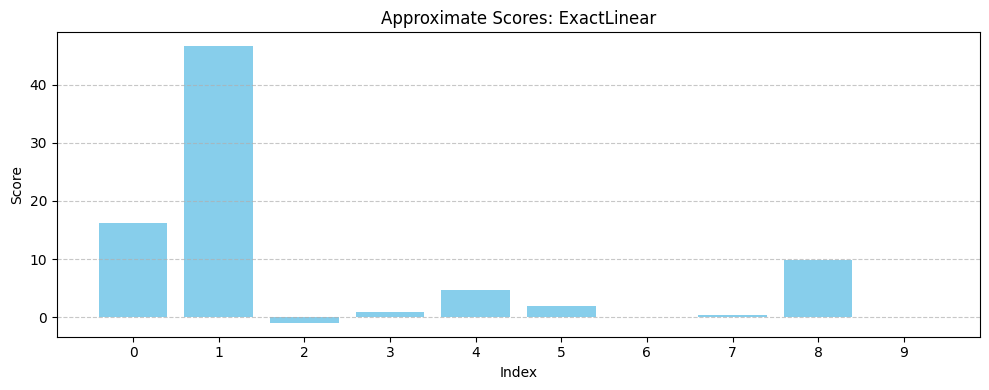

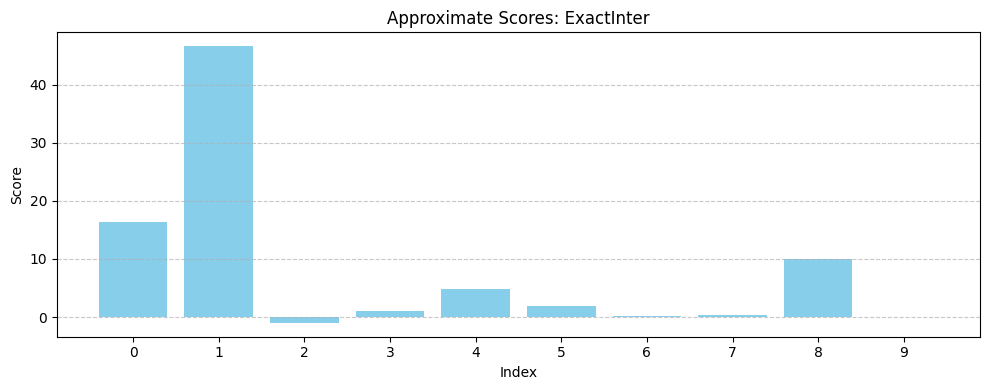

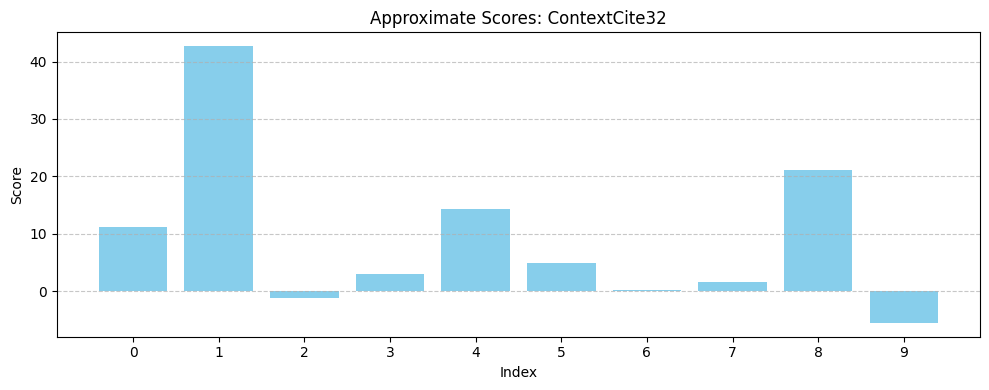

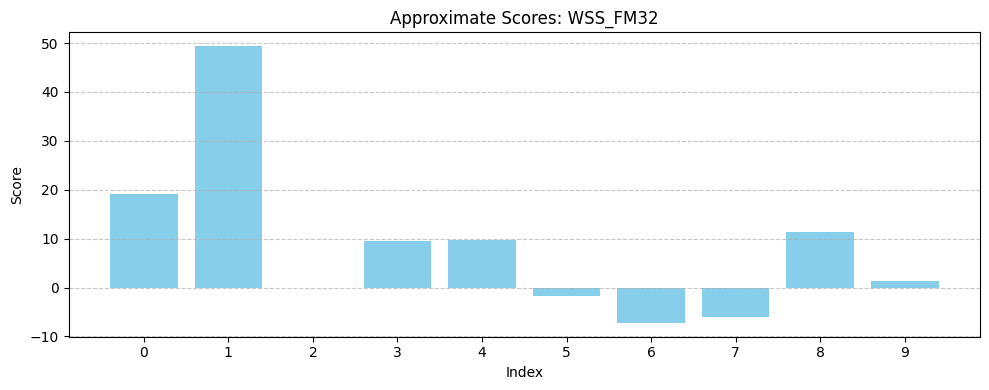

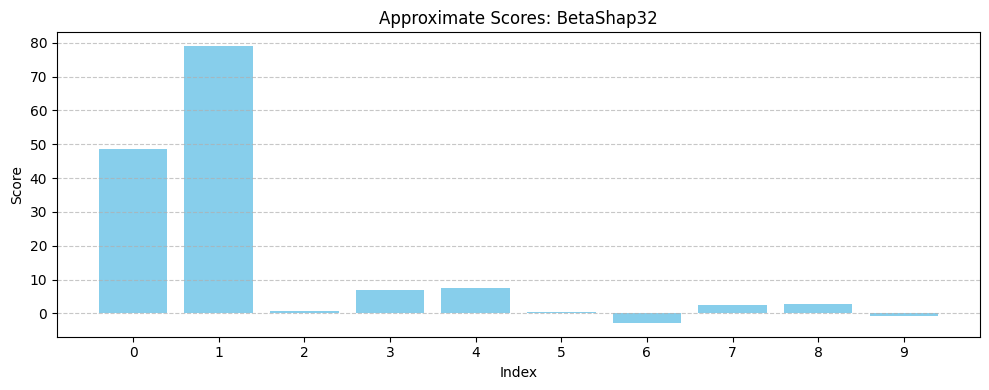

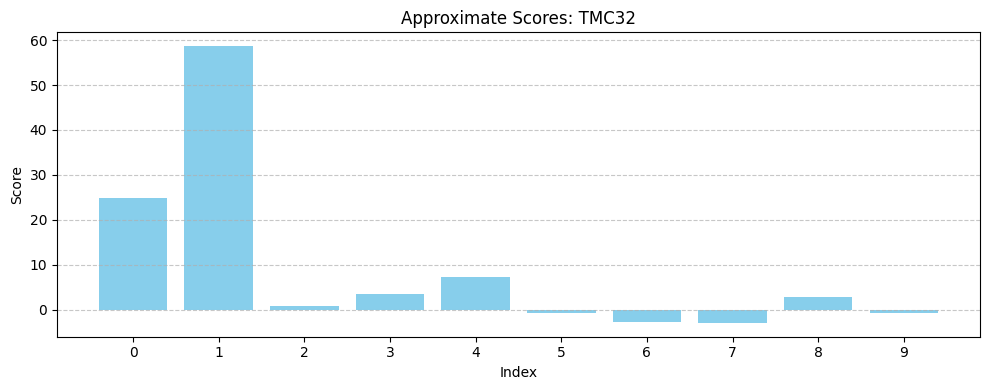

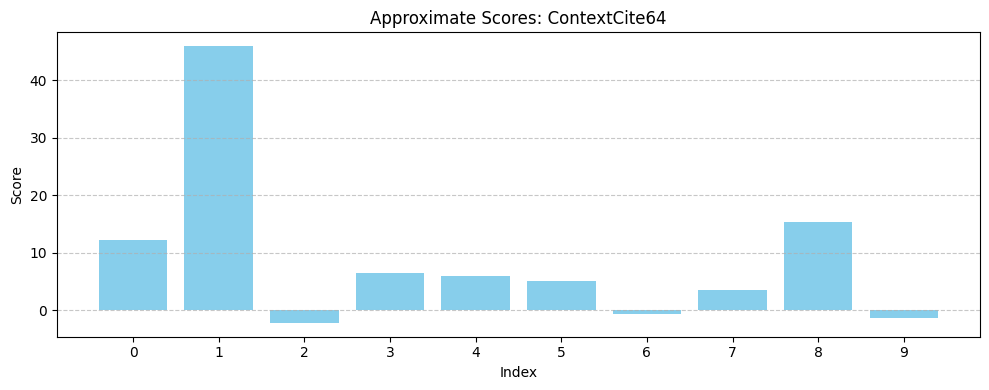

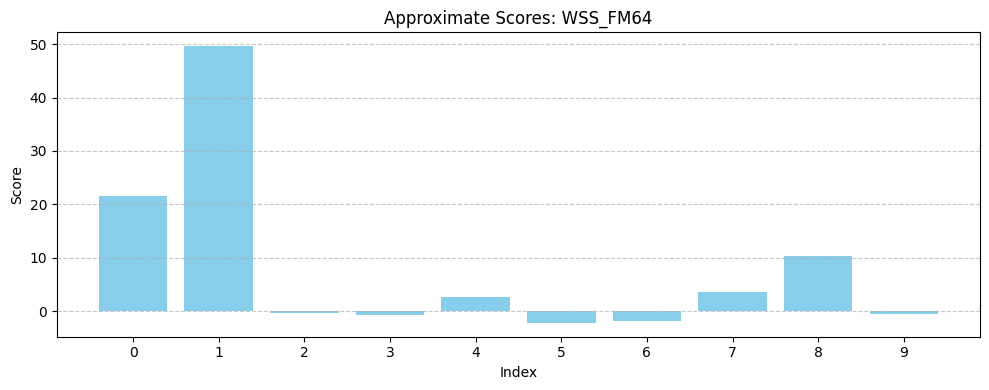

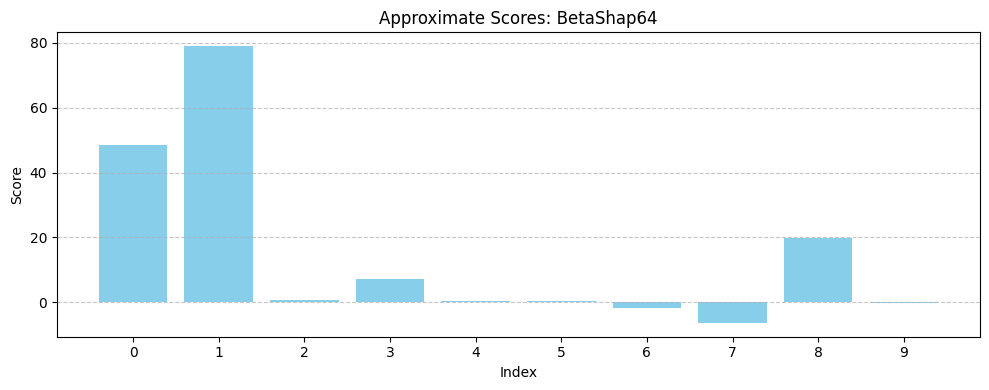

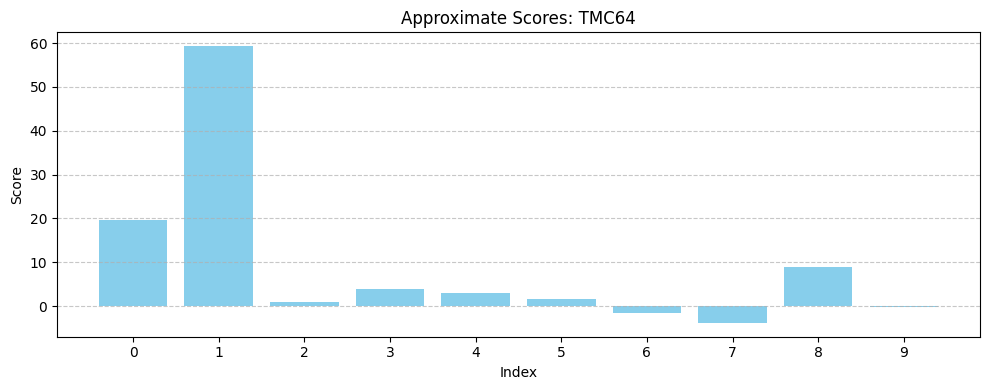

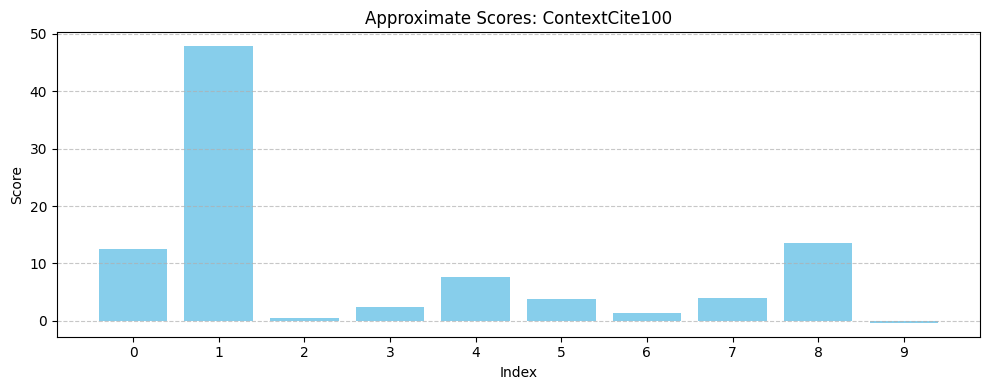

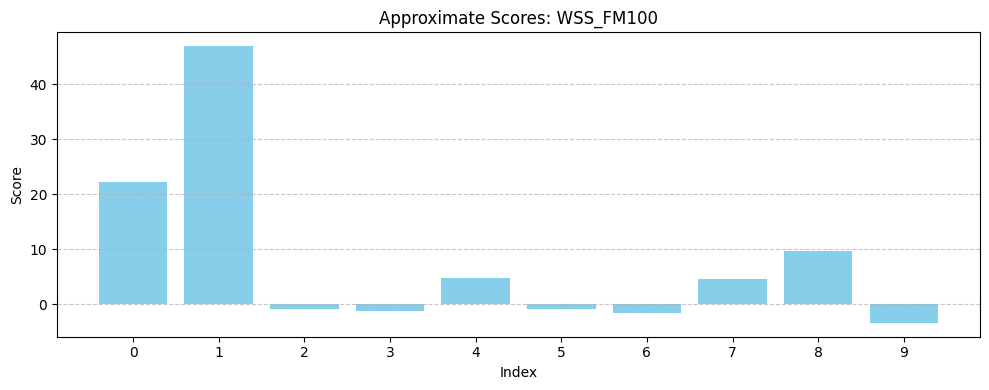

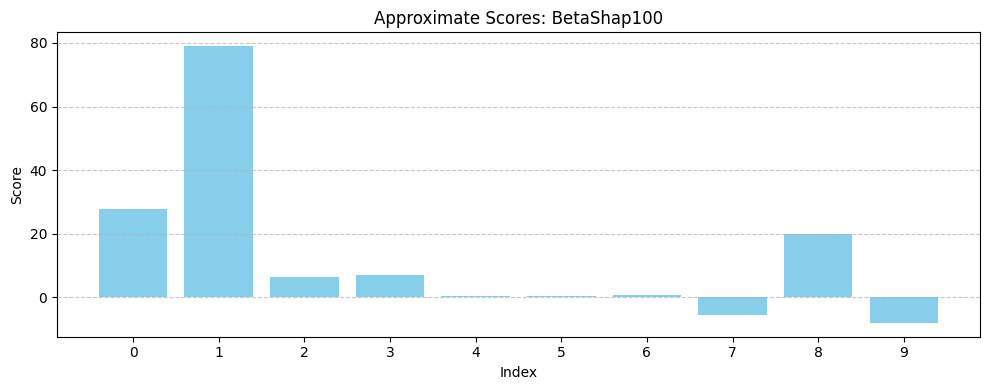

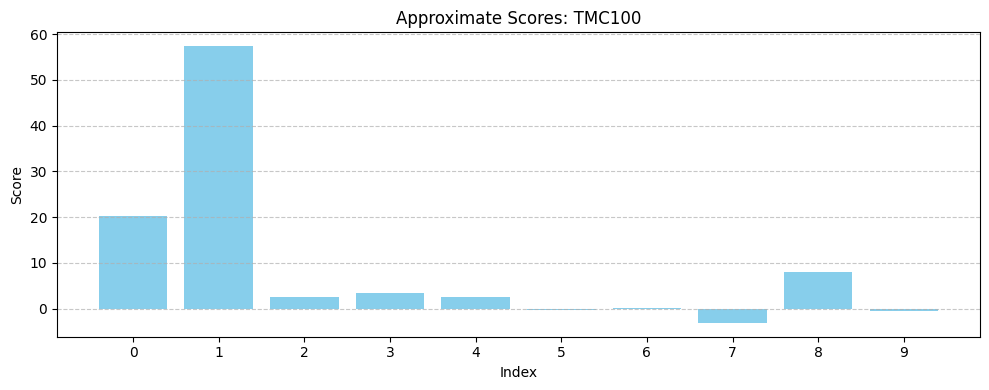

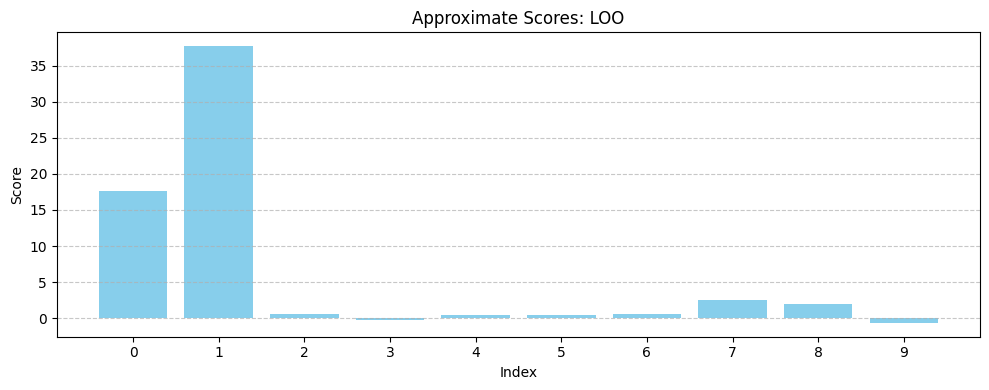

In [9]:
import matplotlib.pyplot as plt

method_scores = {}

for result in all_results:
    for method, scores in result.items():
        if scores is not None:
            method_scores[method] = np.round(scores, 4)

for method, scores in method_scores.items():
    plt.figure(figsize=(10, 4))
    plt.bar(range(len(scores)), scores, color='skyblue')
    plt.title(f"Approximate Scores: {method}")
    plt.xlabel("Index")
    plt.ylabel("Score")
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.xticks(range(len(scores)))
    plt.tight_layout()
    plt.show()


In [15]:
F[1]

array([-5.91692194,  0.        , -9.30488868, -4.64214646, -3.53554757,
        5.56864836, -3.70412295,  0.16745864, -8.74169693, -0.81538618])

In [13]:
df.context[19]

'["The \'Font of Resonance\' is the sacred spring located deep within the ancient Elderwood forest.", "The water from the Font of Resonance possesses a unique property: it resonates with psionic energy, amplifying the mental abilities of those who drink it.", "The water from the Spring of Clarity possesses a unique property: it grants temporary visions of the future to those who drink it.", "The water from the Pool of Serenity possesses a unique property: it instills a deep sense of peace and calm in those who drink it.", "Psionic energy is the energy of thought and consciousness.", "Drinking from the font is part of a traditional ritual.", "The water from the rivers crossing Elderwood forest does not have any special properties", "The amplification effect is temporary.", "The Font of Resonance is guarded by silent protectors.", "Ancient carvings surround the spring."]'